In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs detected:", tf.config.list_physical_devices('GPU'))



TensorFlow version: 2.19.0
Built with CUDA: True
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow import keras
from tensorflow.keras import layers, models

def create_cnn_model(input_shape=(19, 19, 1), learning_rate=0.001):

    model = models.Sequential([
        keras.Input(shape=input_shape),

        #First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        #Flatten + Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),


        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model



def preprocess_data(granger_matrices, labels, test_size=0.2, val_size=0.1, random_state=42):
    #add new channel to work with cnn
    X = granger_matrices[..., np.newaxis].astype(np.float32)

    #split train_Val and test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, labels, test_size=test_size, random_state=random_state, stratify=labels
    )
    #split train and val
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted,
        random_state=random_state, stratify=y_temp
    )

    return {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test
    }


def plot_training_history(history):

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].legend(fontsize=10)


    # Plot loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss')
    axes[1].legend(fontsize=10)


    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names=None):

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def evaluate_model(model, X_test, y_test, class_names=None):

    y_pred_proba = model.predict(X_test, verbose=0)
    if len(y_pred_proba.shape) > 1 and y_pred_proba.shape[1] > 1:
        y_pred = np.argmax(y_pred_proba, axis=1)
    else:
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()


    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}\n")

    print(classification_report(y_test, y_pred, target_names=class_names))

    plot_confusion_matrix(y_test, y_pred, class_names)

    return y_pred


def visualize_matrices(granger_matrices, labels, n_samples=4):

    idx = np.random.choice(len(granger_matrices), n_samples, replace=False)

    fig, axes = plt.subplots(1, n_samples, figsize=(4*n_samples, 4))

    for i, ax in enumerate(axes):
        matrix = granger_matrices[idx[i]]
        label = labels[idx[i]]

        im = ax.imshow(matrix, cmap='viridis')
        ax.set_title(f'Label: {label}')
        ax.set_xticks(range(19))
        ax.set_yticks(range(19))
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.grid(False)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()





In [4]:
from google.colab import drive

#add data to drive and keep in folder and name it data
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:

# Load healthy
H_data = np.load("drive/MyDrive/data/H_data.npy")

# Load MDD
MDD_data = np.load("drive/MyDrive/data/MDD_data.npy")


[[[1.000e+00 1.600e-03 3.000e-04 ... 8.530e-02 4.500e-03 0.000e+00]
  [8.000e-04 1.000e+00 1.003e-01 ... 6.000e-04 1.070e-02 2.908e-01]
  [0.000e+00 0.000e+00 1.000e+00 ... 0.000e+00 2.000e-04 0.000e+00]
  ...
  [6.000e-03 0.000e+00 1.900e-03 ... 1.000e+00 3.000e-04 5.000e-04]
  [0.000e+00 1.000e-04 6.200e-03 ... 0.000e+00 1.000e+00 0.000e+00]
  [0.000e+00 1.840e-01 1.000e-04 ... 8.700e-03 3.140e-02 1.000e+00]]

 [[1.000e+00 5.500e-03 2.710e-02 ... 7.352e-01 3.810e-02 8.300e-03]
  [8.330e-02 1.000e+00 1.700e-02 ... 0.000e+00 7.000e-04 1.375e-01]
  [1.228e-01 5.680e-02 1.000e+00 ... 1.494e-01 3.100e-03 1.283e-01]
  ...
  [2.356e-01 1.000e-04 4.700e-03 ... 1.000e+00 2.430e-02 6.510e-01]
  [9.390e-02 2.740e-02 1.200e-03 ... 1.400e-03 1.000e+00 1.565e-01]
  [1.062e-01 2.300e-03 4.000e-04 ... 9.180e-02 1.160e-02 1.000e+00]]

 [[1.000e+00 0.000e+00 1.000e-04 ... 9.720e-02 1.410e-02 1.000e-04]
  [1.400e-03 1.000e+00 1.700e-03 ... 7.388e-01 5.417e-01 4.510e-02]
  [0.000e+00 0.000e+00 1.000e+00

Data shape: (35524, 19, 19)
Labels shape: (35524,)
Counts: [17557 17967]


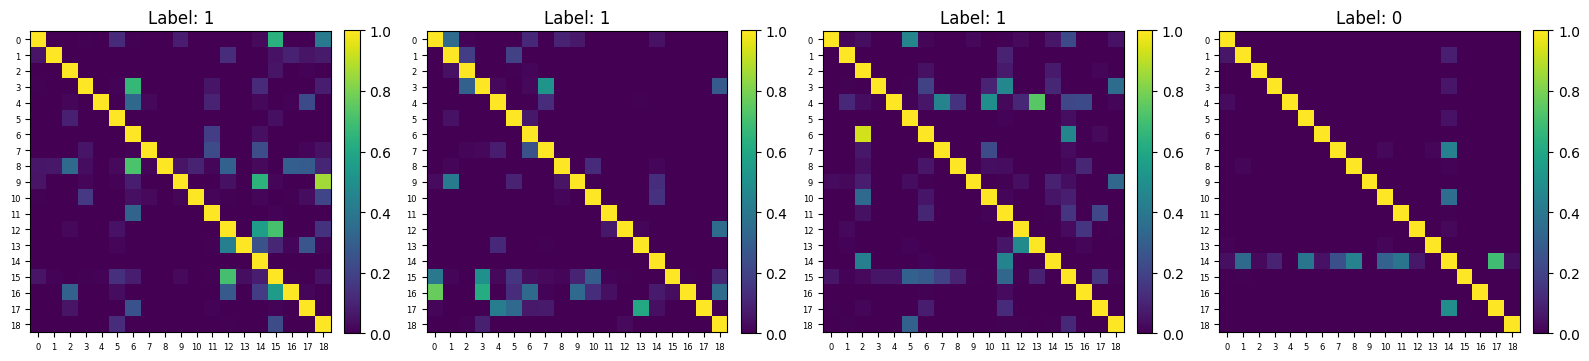

Split Data
Training set: (24866, 19, 19, 1)
Validation set: (5329, 19, 19, 1)
Test set: (5329, 19, 19, 1)

Create/Train Model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 19, 19, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 19, 19, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       331,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,993 (1.27 MB)

 Trainable params: 332,673 (1.27 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6765 - loss: 0.6421 - val_accuracy: 0.7103 - val_loss: 0.5582 - learning_rate: 0.0010
Epoch 2/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7530 - loss: 0.5032 - val_accuracy: 0.7358 - val_loss: 0.5382 - learning_rate: 0.0010
Epoch 3/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7760 - loss: 0.4621 - val_accuracy: 0.8026 - val_loss: 0.4128 - learning_rate: 0.0010
Epoch 4/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7933 - loss: 0.4432 - val_accuracy: 0.8125 - val_loss: 0.4040 - learning_rate: 0.0010
Epoch 5/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8105 - loss: 0.4030 - val_accuracy: 0.8319 - val_loss: 0.3626 - learning_rate: 0.0010
Epoch 6/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8358 - loss: 0.3734 - val_accuracy: 0.8459 - val_loss: 0.3444 - learning_rate: 0.0010
Epoch 7/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8334 - loss: 0.3567 -

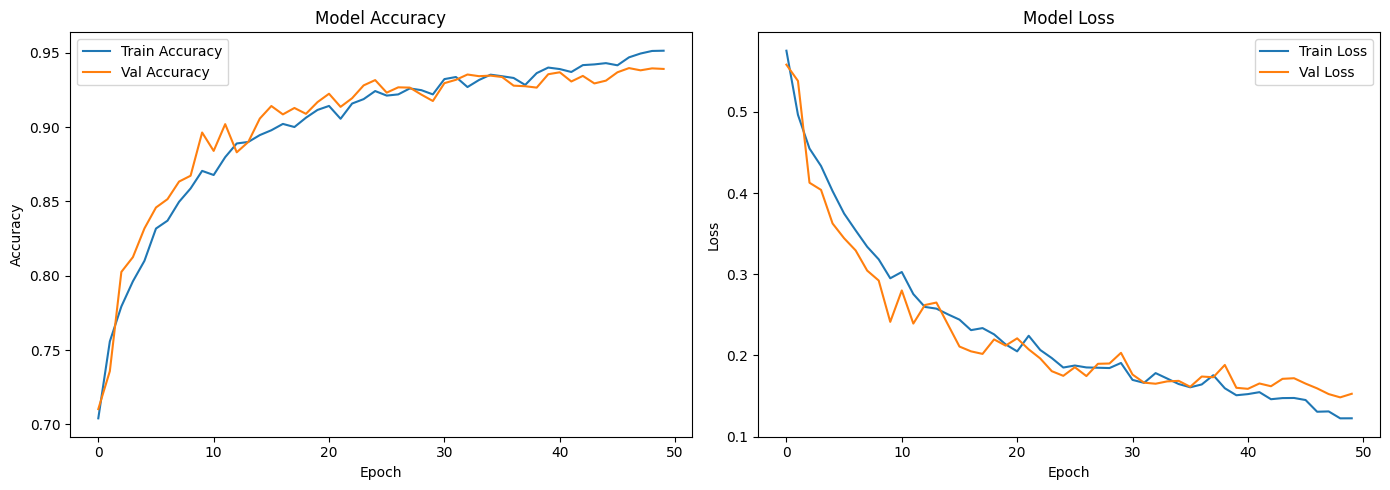

Evaluate on Test Set

Test Accuracy: 0.9334

Classification Report:
              precision    recall  f1-score   support

           H       0.94      0.93      0.93      2634
         MDD       0.93      0.94      0.93      2695

    accuracy                           0.93      5329
   macro avg       0.93      0.93      0.93      5329
weighted avg       0.93      0.93      0.93      5329



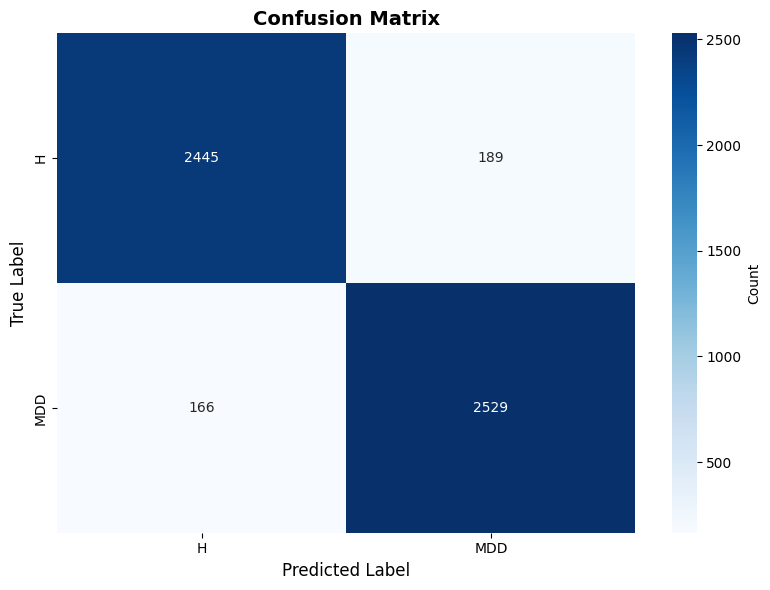


Save Model
Model saved as: /content/drive/MyDrive/phys188models/granger_cnn_model_20251209_121456.keras


In [5]:


# Load healthy
H_data = np.load("drive/MyDrive/data/H_data.npy")

# Load MDD
MDD_data = np.load("drive/MyDrive/data/MDD_data.npy")

# Create labels
H_labels = np.zeros(len(H_data), dtype=int)
MDD_labels = np.ones(len(MDD_data), dtype=int)

# Combine data + labels
granger_matrices = np.concatenate([H_data, MDD_data], axis=0)
labels = np.concatenate([H_labels, MDD_labels], axis=0)

print("Data shape:", granger_matrices.shape)
print("Labels shape:", labels.shape)
print("Counts:", np.bincount(labels))

visualize_matrices(granger_matrices, labels, n_samples=4)




data = preprocess_data(granger_matrices, labels, test_size=0.15, val_size=0.15)

print(f"Training set: {data['X_train'].shape}")
print(f"Validation set: {data['X_val'].shape}")
print(f"Test set: {data['X_test'].shape}\n")



model = create_cnn_model(learning_rate=0.001)
model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

history = model.fit(
    data['X_train'], data['y_train'],
    validation_data=(data['X_val'], data['y_val']),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)



plot_training_history(history)


#make sure to keep right order of class names
class_names = ['H', 'MDD']
y_pred = evaluate_model(model, data['X_test'], data['y_test'], class_names)



import os
from datetime import datetime

save_dir = "/content/drive/MyDrive/phys188models"
os.makedirs(save_dir, exist_ok=True)


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"{save_dir}/granger_cnn_model_{timestamp}.keras"
model.save(model_path)

print(f"Model saved as: {model_path}")


In [6]:
pip install -q -U keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 11.5 MB/s eta 0:00:00


In [7]:
import keras_tuner as kt

In [8]:
def build_cnn_model(hp):
    model = keras.Sequential()

    model.add(keras.Input(shape=(19, 19, 1)))

    num_blocks = hp.Int("num_blocks", 2, 4)

    activation = hp.Choice("activation", ["relu"])

    filters_start = hp.Int("filters_start", 16, 128, step=16)

    for i in range(num_blocks):
        filters = filters_start * (2 ** i)

        model.add(layers.Conv2D(
            filters=filters,
            kernel_size=hp.Choice(f"kernel_size_{i}", [3, 5]),
            activation=activation,
            padding="same"
        ))
        model.add(layers.BatchNormalization())


        if hp.Boolean(f"pool_block_{i}"):
            model.add(layers.MaxPooling2D(pool_size=2))


        model.add(layers.Dropout(
            hp.Float(f"dropout_block_{i}", 0.0, 0.5, step=0.1)
        ))

    model.add(layers.Flatten())
    model.add(layers.Dense(
        hp.Int("dense_units", 64, 512, step=64),
        activation=activation
    ))
    model.add(layers.Dropout(
        hp.Float("dense_dropout", 0.0, 0.5, step=0.1)
    ))

    lr = hp.Float("learning_rate", 1e-5, 1e-2, sampling="log")
    optimizer_name = hp.Choice("optimizer", ["adam"])

    if optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(lr)
    elif optimizer_name == "rmsprop":
        optimizer = keras.optimizers.RMSprop(lr)
    else:
        optimizer = keras.optimizers.SGD(lr)

    # Output
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    return model


In [9]:
tuner = kt.Hyperband(
    build_cnn_model,
    objective="val_accuracy",
    max_epochs=30,
    factor=3,
    directory="hypertuning_results",
    project_name="granger_cnn_reduced"
)


early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5
)

tuner.search(
    data['X_train'], data['y_train'],
    validation_data=(data['X_val'], data['y_val']),
    callbacks=[early_stop],
    epochs=50,
    batch_size=kt.HyperParameters().Choice("batch_size", [32, 64, 128])
)


best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.get_best_models(1)[0]

print("Best hyperparameters:")
for hp_name in best_hp.values.keys():
    print(hp_name, ":", best_hp.get(hp_name))


Trial 90 Complete [00h 00m 37s]
val_accuracy: 0.8915368914604187

Best val_accuracy So Far: 0.9474573135375977
Total elapsed time: 01h 05m 01s
Best hyperparameters:
num_blocks : 3
activation : relu
filters_start : 112
kernel_size_0 : 3
pool_block_0 : False
dropout_block_0 : 0.0
kernel_size_1 : 3
pool_block_1 : True
dropout_block_1 : 0.30000000000000004
dense_units : 512
dense_dropout : 0.0
learning_rate : 0.0006692581046953691
optimizer : adam
kernel_size_2 : 3
pool_block_2 : False
dropout_block_2 : 0.4
kernel_size_3 : 3
pool_block_3 : True
dropout_block_3 : 0.4
tuner/epochs : 30
tuner/initial_epoch : 10
tuner/bracket : 2
tuner/round : 2
tuner/trial_id : 0067


Epoch 1/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.6686 - loss: 0.8078 - val_accuracy: 0.7968 - val_loss: 0.4136
Epoch 2/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8016 - loss: 0.4050 - val_accuracy: 0.7970 - val_loss: 18.3127
Epoch 3/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8663 - loss: 0.3180 - val_accuracy: 0.9084 - val_loss: 0.2119
Epoch 4/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9162 - loss: 0.1996 - val_accuracy: 0.9165 - val_loss: 0.1931
Epoch 5/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9319 - loss: 0.1630 - val_accuracy: 0.9276 - val_loss: 0.1733
Epoch 6/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9509 - loss: 0.1199 - val_accuracy: 0.9308 - val_loss: 0.1632
Epoch 7/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9622 - loss: 0.0990 - val_accuracy: 0.9375 - val_loss: 0.1633
Epoch 8/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9715

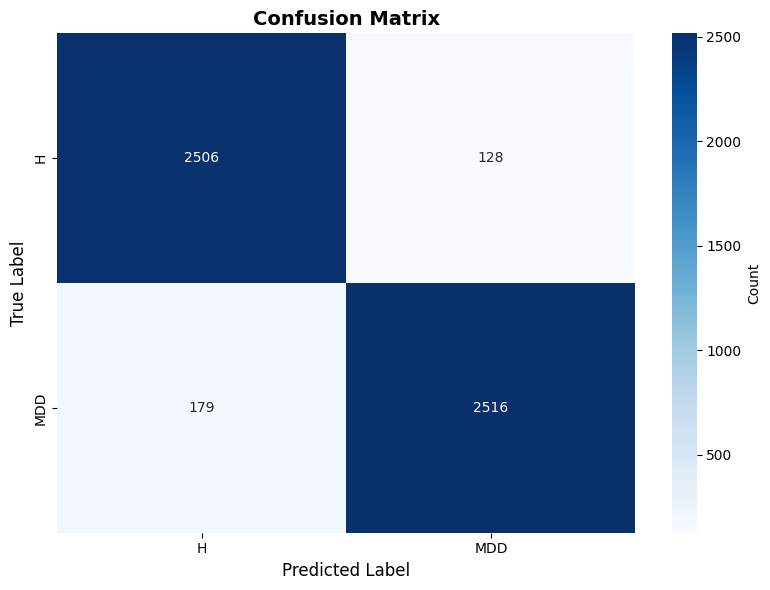

array([0, 1, 0, ..., 1, 0, 0])

In [18]:
best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)

early_stop_final = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    verbose=1
)

history = model.fit(
    data['X_train'],
    data['y_train'],
    epochs=100,
    batch_size=16,
    validation_data=(data['X_val'], data['y_val']),
    callbacks=[early_stop_final],
    verbose=1
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
path =  f"{save_dir}/granger_cnn_model_{timestamp}.keras"
model.save(path)

evaluate_model(model, data['X_test'], data['y_test'], class_names=['H', 'MDD'])
